# Using `salter` to examine the transit residuals

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from salter import LightCurve
import matplotlib.pyplot as plt
import h5py

# Open the HDF5 archive of Kepler light curves
hdf5_file = h5py.File("data/light_curves.hdf5", 'r')

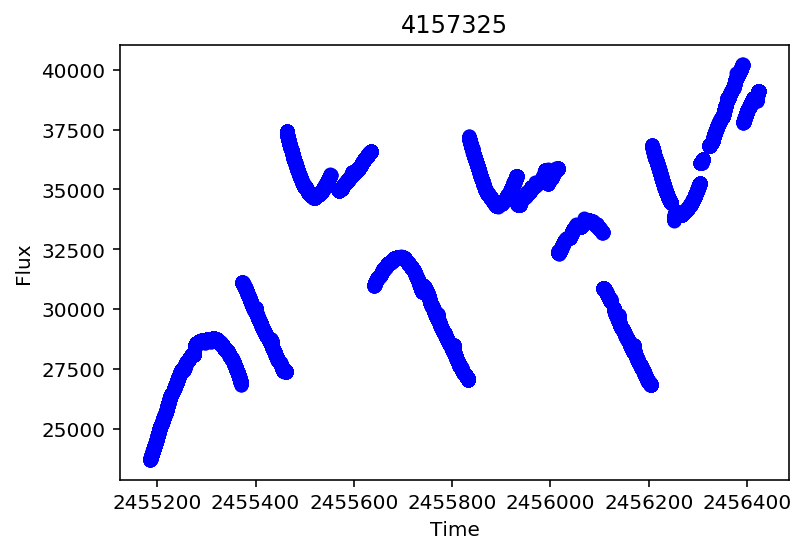

In [2]:
# Specify a KIC number to get the light curve
# Here are some numbers to try: 9705459, 10386922, 9651668
kic_number = 4157325
whole_lc = LightCurve.from_hdf5(hdf5_file, kic_number)

# Plot the light curve (raw SAP flux)
whole_lc.plot()

Here's how you can quickly see what the transit parameters are:

In [3]:
for attr in dir(whole_lc.params):
    if not attr.startswith('_'):
        print("{0}: {1}".format(attr, getattr(whole_lc.params, attr)))

a: 9.653804181717652
b: 0.775
duration: 0.13925833333333335
ecc: 0
fp: None
inc: 85.39538373938178
limb_dark: quadratic
per: 6.31943553
rp: 0.021618047784201053
t0: 2454965.22892
t_secondary: None
u: (0.49869999999999998, 0.1772)
w: 90


In [4]:
from salter import subtract_add_divide

extra_oot_time = 1.0 # [durations]; Extra transit durations to keep before ingress/after egress

# Mask out-of-transit portions of light curves, chop into individual transits
near_transit = LightCurve(**whole_lc.mask_out_of_transit(oot_duration_fraction=extra_oot_time))
transits = near_transit.get_transit_light_curves()

# Normalize all transits with the subtract-add-divide method, 
# using a second order polynomial
subtract_add_divide(whole_lc, transits)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/salter/salter/lightcurve.py:395: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:396: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/salter/salter/lightcurve.py:397: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the f

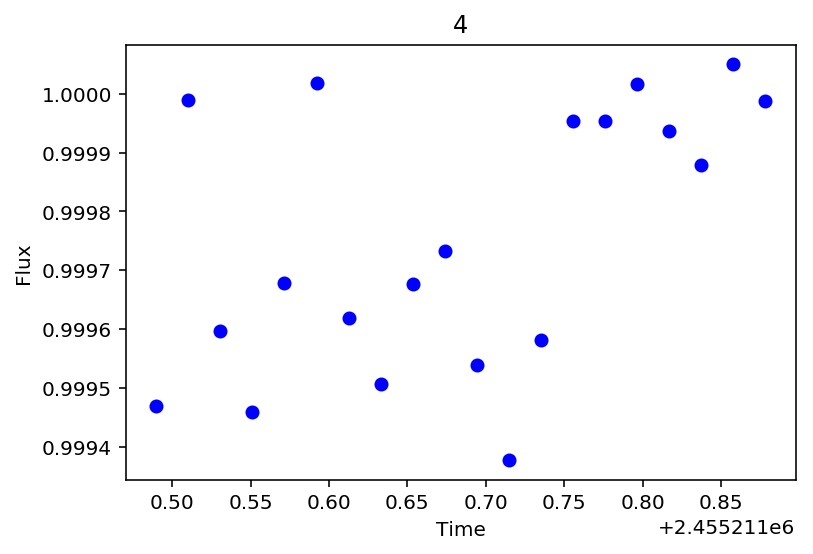

In [5]:
# You can pick on an individual transit from the list of transits like this: 

sample_transit = transits[4]

sample_transit.plot()

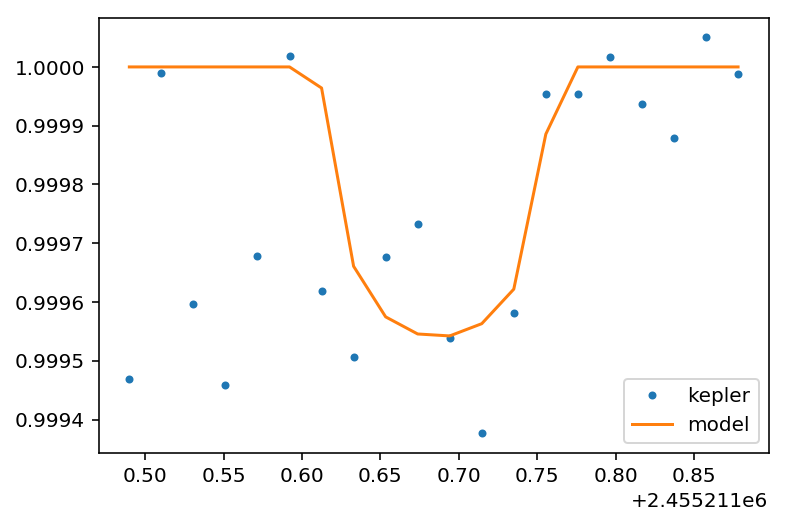

In [6]:
# Compute mandel & agol model, plot it over the observations
model = sample_transit.transit_model()

plt.plot(sample_transit.times.jd, sample_transit.fluxes, '.', label='kepler')
plt.plot(sample_transit.times.jd, model, label='model')
plt.legend()

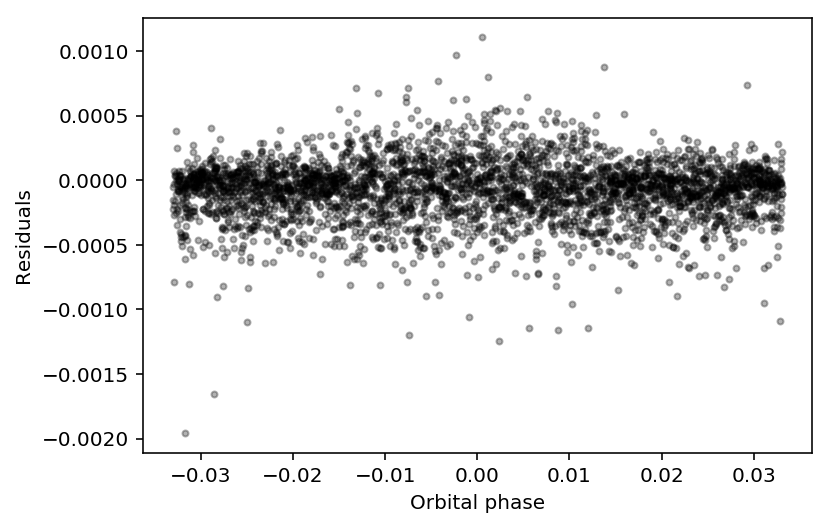

In [7]:
# plot residuals of all transits:

for transit in transits:
    plt.plot(transit.phases(), transit.fluxes - transit.transit_model(), 'k.', alpha=0.3)
plt.xlabel('Orbital phase')
plt.ylabel('Residuals')

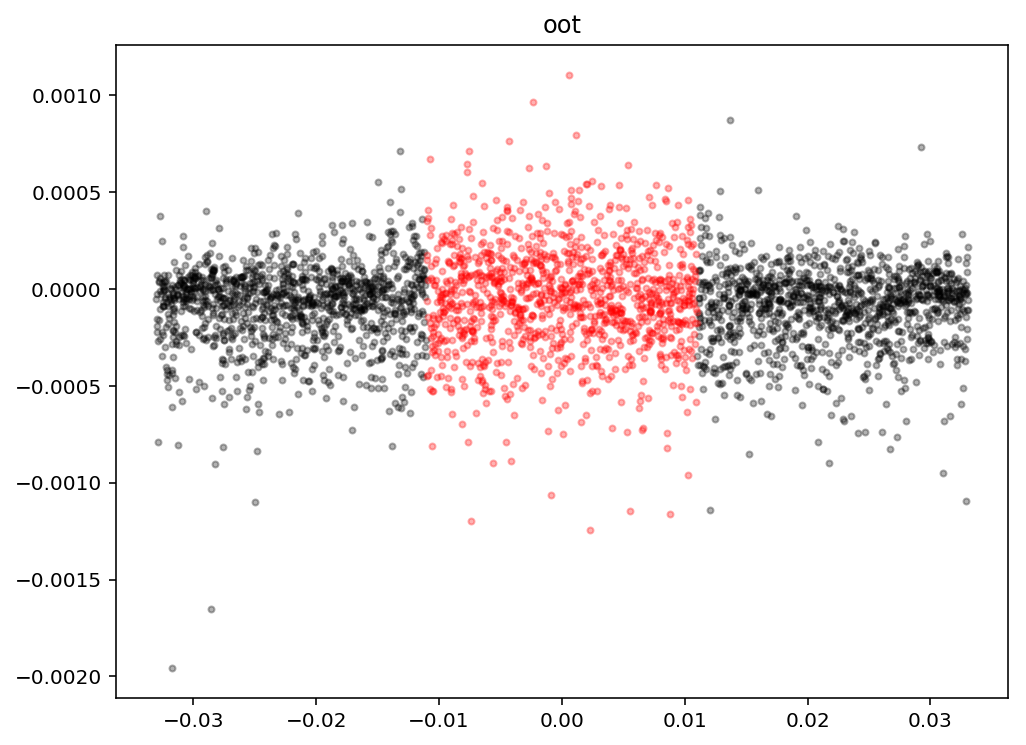

In [10]:
import numpy as np
from salter import concatenate_transit_light_curves

def in_transit_phase(params):
    return params.duration/2/params.per

all_transits = concatenate_transit_light_curves(transits)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True, sharey=True)
p, r = all_transits.phases(), all_transits.fluxes - all_transits.transit_model()

out_of_transit = ((-in_transit_phase(whole_lc.params) > all_transits.phases()) | 
                  (in_transit_phase(whole_lc.params) < all_transits.phases()))
in_transit = np.logical_not(out_of_transit)

ax.set_title('oot')
ax.plot(p[out_of_transit], r[out_of_transit], 'k.', alpha=0.3)

ax.plot(p[in_transit], r[in_transit], 'r.', alpha=0.3)

In [11]:
from scipy.stats import shapiro, ks_2samp

# Are the oot fluxes distributed differently than in-transit fluxes?
print(ks_2samp(r[out_of_transit], r[in_transit]))

# Are the oot flux distributions similar before and after the transit?
print(ks_2samp(r[out_of_transit & (p < 0)], r[out_of_transit & (p > 0)]))

# Are the in-transits flux distributions similar before and after the transit?
print(ks_2samp(r[in_transit & (p < 0)], r[in_transit & (p > 0)]))

Ks_2sampResult(statistic=0.14595606108494186, pvalue=4.9797573814918306e-16)
Ks_2sampResult(statistic=0.031453510177639865, pvalue=0.55572798573886839)
Ks_2sampResult(statistic=0.049873428058141434, pvalue=0.40860332015692841)
